In [8]:
import dask # get error with xr.open without
import earthaccess
import geopandas as gpd
import glob
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr

#### Get Pixel Cloud

In [4]:
filepath = '../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_011_345_239R_20240227T044209_20240227T044220_PIC0_01.nc'

In [5]:
ds_PIXC = xr.open_mfdataset(filepath, group = 'pixel_cloud', engine='h5netcdf')

In [6]:
ds_PIXC

<xarray.Dataset> Size: 2GB
Dimensions:                                (points: 5743490, complex_depth: 2,
                                            num_pixc_lines: 3264)
Coordinates:
    latitude                               (points) float64 46MB dask.array<chunksize=(522136,), meta=np.ndarray>
    longitude                              (points) float64 46MB dask.array<chunksize=(522136,), meta=np.ndarray>
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 46MB dask.array<chunksize=(957249,), meta=np.ndarray>
    range_index                            (points) float64 46MB dask.array<chunksize=(957249,), meta=np.ndarray>
    interferogram                          (points, complex_depth) float32 46MB dask.array<chunksize=(1435873, 1), meta=np.ndarray>
    power_plus_y                           (points) float32 23MB dask.array<chunksize=(957249,), meta=np.ndarray>
    power_minus_y                          (points) float32 23MB dask.array<chunksize=(957249,), meta=np.ndarray>
    coherent_power                         (points) float32 23MB dask.array<chunksize=(957249,), meta=np.ndarray>
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB dask.array<chunksize=(3264,), meta=np.ndarray>
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB dask.array<chunksize=(3264,), meta=np.ndarray>
    data_window_first_valid                (num_pixc_lines) float64 26kB dask.array<chunksize=(3264,), meta=np.ndarray>
    data_window_last_valid                 (num_pixc_lines) float64 26kB dask.array<chunksize=(3264,), meta=np.ndarray>
    data_window_first_cross_track          (num_pixc_lines) float32 13kB dask.array<chunksize=(3264,), meta=np.ndarray>
    data_window_last_cross_track           (num_pixc_lines) float32 13kB dask.array<chunksize=(3264,), meta=np.ndarray>
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3264
    interferogram_size_range:    4662
    looks_to_efflooks:           1.5436871518708457
    num_azimuth_looks:           7.0
    azimuth_offset:              8

In [ ]:
# ds_PIXC.sizes['points']

In [43]:
# list(ds_PIXC.keys())

In [78]:
pre_mask = np.where(ds_PIXC.classification > 1)[0].tolist()

In [81]:
# Excluding layover_impact as it is is only useful for aggregated heights
variables = ['azimuth_index', 'range_index', 'water_frac', 'water_frac_uncert',
             'classification', 'false_detection_rate', 'missed_detection_rate',
             'prior_water_prob', 'bright_land_flag', 'height', 'geoid',
             'ancillary_surface_classification_flag', 'interferogram_qual',
             'classification_qual', 'geolocation_qual', 'sig0_qual']

In [83]:
d = {}
for var in variables:
    d[var] = ds_PIXC[var][pre_mask]

In [87]:
# # Make GeoDataFrame
# gdf = gpd.GeoDataFrame(data=d, index=range(len(gq)),
#                         geometry=gpd.points_from_xy(ds_PIXC.longitude,
#                                                     ds_PIXC.latitude))

# Make DataFrame
df = pd.DataFrame(data=d, index=range(len(pre_mask)))

In [162]:
n = 27
flag_sum = 0

for i in range(n):
    # print('--')
    # print(i)
    print
    flag_sum += 2**i
    # print(flag_sum)

In [193]:
np.set_printoptions(suppress=True)
np.unique(df.geolocation_qual)

array([    64.,     65.,     66.,     67.,     68.,     69.,     70.,
           71.,   4160.,   4161.,   4162.,   4163.,   4164.,   4165.,
         4166.,   4167., 524352., 524353., 524356., 524357., 524358.,
       524359., 528448., 528449., 528452., 528453., 528454., 528455.])

In [279]:
counts = df.geolocation_qual.value_counts().sort_index()
counts

geolocation_qual
64.0        688758
65.0         24286
66.0           135
67.0            49
68.0        764727
69.0        147990
70.0          2001
71.0           694
4160.0         229
4161.0          18
4162.0           5
4163.0           1
4164.0       16515
4165.0        3697
4166.0          28
4167.0           8
524352.0    123835
524353.0      2727
524356.0    151332
524357.0      9214
524358.0       389
524359.0        41
528448.0        89
528449.0         3
528452.0      3177
528453.0       207
528454.0         1
528455.0         1
Name: count, dtype: int64

In [281]:
counts.index

Index([    64.0,     65.0,     66.0,     67.0,     68.0,     69.0,     70.0,
           71.0,   4160.0,   4161.0,   4162.0,   4163.0,   4164.0,   4165.0,
         4166.0,   4167.0, 524352.0, 524353.0, 524356.0, 524357.0, 524358.0,
       524359.0, 528448.0, 528449.0, 528452.0, 528453.0, 528454.0, 528455.0],
      dtype='float64', name='geolocation_qual')

(0.0, 32.0)

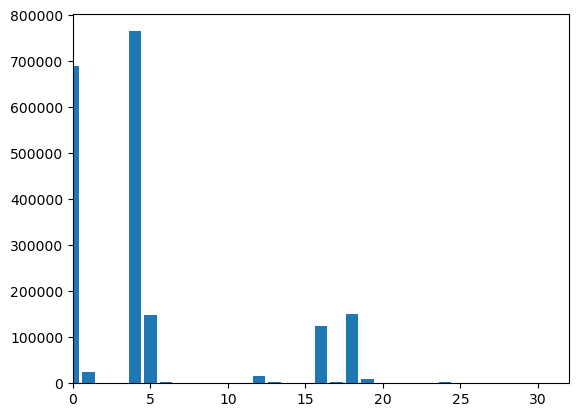

In [289]:
plt.bar(x=range(len(counts)), height=counts)
plt.xlim(0,32)

In [209]:
flags = [64, 65, 66, 67, 68, 69, 70, 71]

In [213]:
num_flagged = []
for i in flags:
    num_flagged.append(df[df['geolocation_qual'] == i].shape[0])

In [214]:
num_flagged

[688758, 24286, 135, 49, 764727, 147990, 2001, 694]

In [301]:
# We only want to allow pixels with layover_significant or 
# phase_noise_suspect, but so many pixels have xovercal_suspect
# this will keep those that have xovercal_suspect and/or
# layover_significant and/or phase_noise_suspect
flags = np.logical_or.reduce([ds_PIXC.geolocation_qual < 4, 
                                ds_PIXC.geolocation_qual == 64,
                                ds_PIXC.geolocation_qual == 65,
                                ds_PIXC.geolocation_qual == 66,
                                ds_PIXC.geolocation_qual == 67])

# Keep pixels where class is not land and flag is one of the above
mask = np.where(np.logical_and(ds_PIXC.classification > 1, flags))[0]

In [300]:
len(mask) / ds_PIXC.sizes['points']

0.12418024580873302

In [328]:
msk = np.where(ds_PIXC.classification > 1)[0]

In [330]:
len(msk) / ds_PIXC.sizes['points']

0.3378010582415918

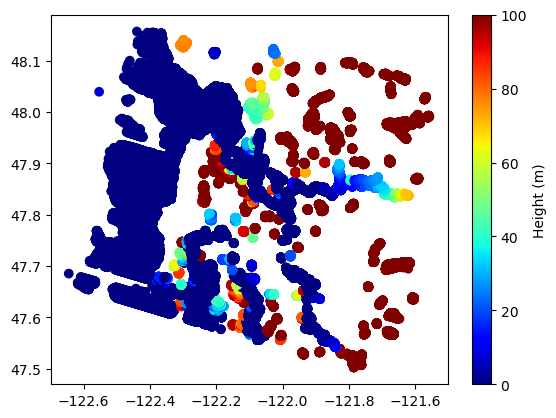

In [302]:
plt.scatter(x=ds_PIXC.longitude[mask], y=ds_PIXC.latitude[mask], c=ds_PIXC.height[mask], cmap='jet')
plt.clim((0,100))
plt.colorbar().set_label('Height (m)')

In [ ]:
gdf = gpd.GeoDataFrame(ds_PIXC.to_dataarray(),
                       geometry=gpd.points_from_xy(ds_PIXC.longitude,
                                                    ds_PIXC.latitude),
                        crs="EPSG:4326")

In [36]:
# When I also filter on the qual flags like Brent does in the PO.DAAC cookbook,
# I get no pixels
mask = np.where(ds_PIXC.classification > 2)
# mask = np.where(np.logical_and(ds_PIXC.classification > 2, ds_PIXC.geolocation_qual < 4))

In [37]:
gdf_PIXC = gpd.GeoDataFrame(ds_PIXC.classification[mask],
                        geometry=gpd.points_from_xy(ds_PIXC.longitude[mask],
                                                    ds_PIXC.latitude[mask]),
                        crs="EPSG:4326")
gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: 'klass'}, inplace=True)

In [38]:
gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)